# Belgium Taffic Sign Dataset

## 1. CARGA DE DATOS

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import math

# Allow image embeding in notebook
%matplotlib inline

In [2]:
def load_data(data_dir, width, height):
    directories = [d for d in os.listdir(data_dir) 
                 if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            labels.append(int(d))
            images.append(skimage.transform.resize(skimage.data.imread(f), (width, height)))
    
    labels=np.array(labels)
    images=np.array(images)
    
    return images, labels

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_data(test_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Model 3: Going Deeper

In [7]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [8]:
class Model3():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,200, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,100, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,62, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [11]:
def evaluate(model, images, labels, imprimir=True):
    #Run predictions against the full test set
    #print(images.shape)
    #print(labels.shape)
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]

    return loss, accuracy 

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs_test=[]
    acc_test=[]
    costs_train=[]
    acc_train=[]
    for i in range(train_counts):
        if i % 50 == 0:
            loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
            costs_test.append(loss_test)
            acc_test.append(accuracy_test)
            loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
            costs_train.append(loss_train)
            acc_train.append(accuracy_train)
            a = model.session.run(model.global_step)
            if imprimir == True:
                print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
                print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
        # ??? improve picking batches
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    
    loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
    

    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(acc_train), label='Entr.')
        plt.plot(np.squeeze(acc_test), label='Valid.')
        plt.ylabel('Precisión')
        plt.xlabel('Iteraciones por decenas')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
        plt.plot(np.squeeze(costs_test), label='Test')
        plt.ylabel('Coste')
        plt.xlabel('iteraciones por decenas')
        plt.show()
    
    return costs_train, acc_train, costs_test, acc_test    

In [12]:
m3=Model3()

   0, Loss: 4.174  Train accuracy: 0.009
   0, Loss: 4.172  Test accuracy: 0.005
  50, Loss: 2.830  Train accuracy: 0.427
  50, Loss: 3.078  Test accuracy: 0.359
 100, Loss: 2.141  Train accuracy: 0.567
 100, Loss: 2.199  Test accuracy: 0.558
 150, Loss: 1.746  Train accuracy: 0.636
 150, Loss: 1.840  Test accuracy: 0.598
 200, Loss: 1.451  Train accuracy: 0.717
 200, Loss: 1.658  Test accuracy: 0.657
 250, Loss: 1.255  Train accuracy: 0.772
 250, Loss: 1.463  Test accuracy: 0.706
 300, Loss: 1.099  Train accuracy: 0.775
 300, Loss: 1.339  Test accuracy: 0.733
 350, Loss: 0.940  Train accuracy: 0.817
 350, Loss: 1.214  Test accuracy: 0.733
 400, Loss: 0.839  Train accuracy: 0.831
 400, Loss: 1.105  Test accuracy: 0.752
 450, Loss: 0.689  Train accuracy: 0.876
 450, Loss: 0.990  Test accuracy: 0.770
 500, Loss: 0.561  Train accuracy: 0.888
 500, Loss: 0.874  Test accuracy: 0.803
 550, Loss: 0.528  Train accuracy: 0.896
 550, Loss: 0.741  Test accuracy: 0.820
 600, Loss: 0.406  Train acc

5100, Loss: 0.054  Train accuracy: 0.984
5100, Loss: 0.859  Test accuracy: 0.847
5150, Loss: 0.134  Train accuracy: 0.963
5150, Loss: 0.863  Test accuracy: 0.846
5200, Loss: 0.050  Train accuracy: 0.990
5200, Loss: 0.496  Test accuracy: 0.904
5250, Loss: 0.033  Train accuracy: 0.994
5250, Loss: 0.451  Test accuracy: 0.907
5300, Loss: 0.024  Train accuracy: 0.994
5300, Loss: 0.426  Test accuracy: 0.915
5350, Loss: 0.017  Train accuracy: 0.996
5350, Loss: 0.579  Test accuracy: 0.893
5400, Loss: 0.017  Train accuracy: 0.996
5400, Loss: 0.430  Test accuracy: 0.913
5450, Loss: 0.016  Train accuracy: 0.997
5450, Loss: 0.465  Test accuracy: 0.911
5500, Loss: 0.057  Train accuracy: 0.983
5500, Loss: 0.798  Test accuracy: 0.864
5550, Loss: 0.018  Train accuracy: 0.997
5550, Loss: 0.523  Test accuracy: 0.902
5600, Loss: 0.031  Train accuracy: 0.990
5600, Loss: 0.694  Test accuracy: 0.859
5650, Loss: 0.113  Train accuracy: 0.978
5650, Loss: 0.592  Test accuracy: 0.892
5700, Loss: 0.057  Train acc

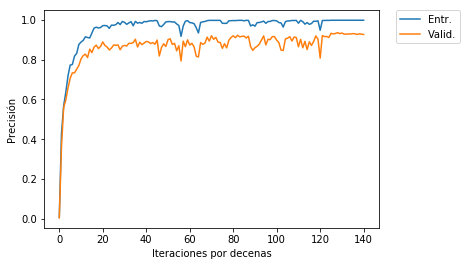

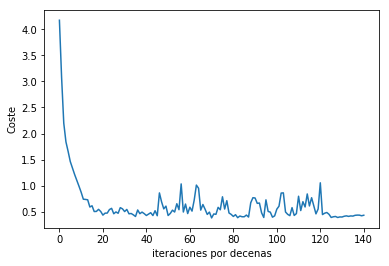

([4.173955,
  2.8301113,
  2.1410024,
  1.7460362,
  1.4512441,
  1.2546418,
  1.0988626,
  0.9401224,
  0.8394513,
  0.6893466,
  0.5605405,
  0.5279968,
  0.40648603,
  0.4145406,
  0.37872022,
  0.31862006,
  0.22788161,
  0.20110734,
  0.20500404,
  0.17938967,
  0.1566086,
  0.14900751,
  0.13684835,
  0.15962614,
  0.120433114,
  0.12687112,
  0.10237259,
  0.07593016,
  0.10259826,
  0.05970142,
  0.07459427,
  0.1055828,
  0.07659448,
  0.053528983,
  0.11904839,
  0.05379365,
  0.081502326,
  0.06826316,
  0.07841596,
  0.04510078,
  0.050794475,
  0.038930275,
  0.031318065,
  0.034791224,
  0.025873525,
  0.026496878,
  0.10603524,
  0.16566436,
  0.09011907,
  0.053046282,
  0.043539505,
  0.04591023,
  0.053012807,
  0.045310598,
  0.06846245,
  0.09012862,
  0.28892067,
  0.12028331,
  0.038190022,
  0.02608126,
  0.054117568,
  0.070212364,
  0.07376969,
  0.15321283,
  0.25241083,
  0.053270932,
  0.04206716,
  0.039878096,
  0.02798062,
  0.019563064,
  0.016612316,
  

In [13]:
train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 7000)

In [15]:
for i in range(5):
    m3_1 = Model3()
    modelos = train_minibatch(m3_1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 7000, False)

6950, Loss: 0.010  Train accuracy: 0.998
6950, Loss: 0.471  Test accuracy: 0.912
6950, Loss: 0.006  Train accuracy: 0.998
6950, Loss: 0.350  Test accuracy: 0.935
6950, Loss: 0.013  Train accuracy: 0.997
6950, Loss: 0.408  Test accuracy: 0.926
6950, Loss: 0.192  Train accuracy: 0.948
6950, Loss: 0.851  Test accuracy: 0.847
6950, Loss: 0.002  Train accuracy: 1.000
6950, Loss: 0.413  Test accuracy: 0.925


### Visualize the Weights

Now that the model has 3 layers, visualizing it's weights is not as straghtforward as before. The fist layer is still a fully connected layer and it's nodes connect to every pixel in the input image, so we can visualize it like before. However, this time, the first layer works tith the second and third layers to arrive at a final classification, so the weights in the first layer don't represent the full picture. But let's try it anyway, and see what we get.

In [40]:
# Print the names of trainable variables.
with m3.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 200)
fully_connected/biases:0 (200,)
fully_connected_1/weights:0 (200, 100)
fully_connected_1/biases:0 (100,)
fully_connected_2/weights:0 (100, 62)
fully_connected_2/biases:0 (62,)


In [45]:
m3_w0 = m3.session.run("fully_connected/weights:0")
m3_w1 = m3.session.run("fully_connected_1/weights:0")
m3_w2 = m3.session.run("fully_connected_2/weights:0")
print("weights0 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w0.shape, m3_w0.min(), m3_w0.max()))
print("weights1 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w1.shape, m3_w1.min(), m3_w1.max()))
print("weights2 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w2.shape, m3_w2.min(), m3_w2.max()))

weights0 shape: (3072, 200)    min: -0.4832    max: 0.6021
weights1 shape: (200, 100)    min: -0.4767    max: 0.3611
weights2 shape: (100, 62)     min: -1.0294    max: 0.5081


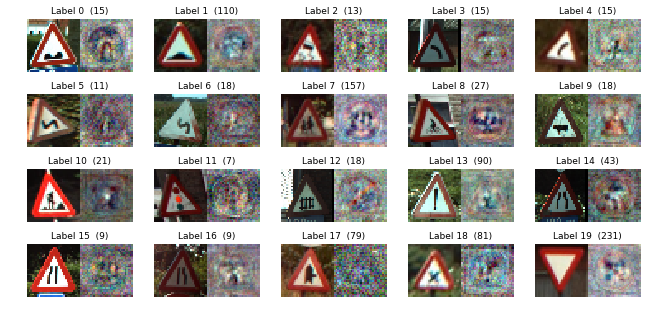

In [42]:
display_weights(m3_w0, 20)

As for layer 2 and 3, their shapes don't correspond to the input image, adn their values simply don't  map to pixels in any meaningful way. There are tricks to visualize them, which I'll get into in the next model. For now, let display the histogramjust to make sure nothing seems out of order.

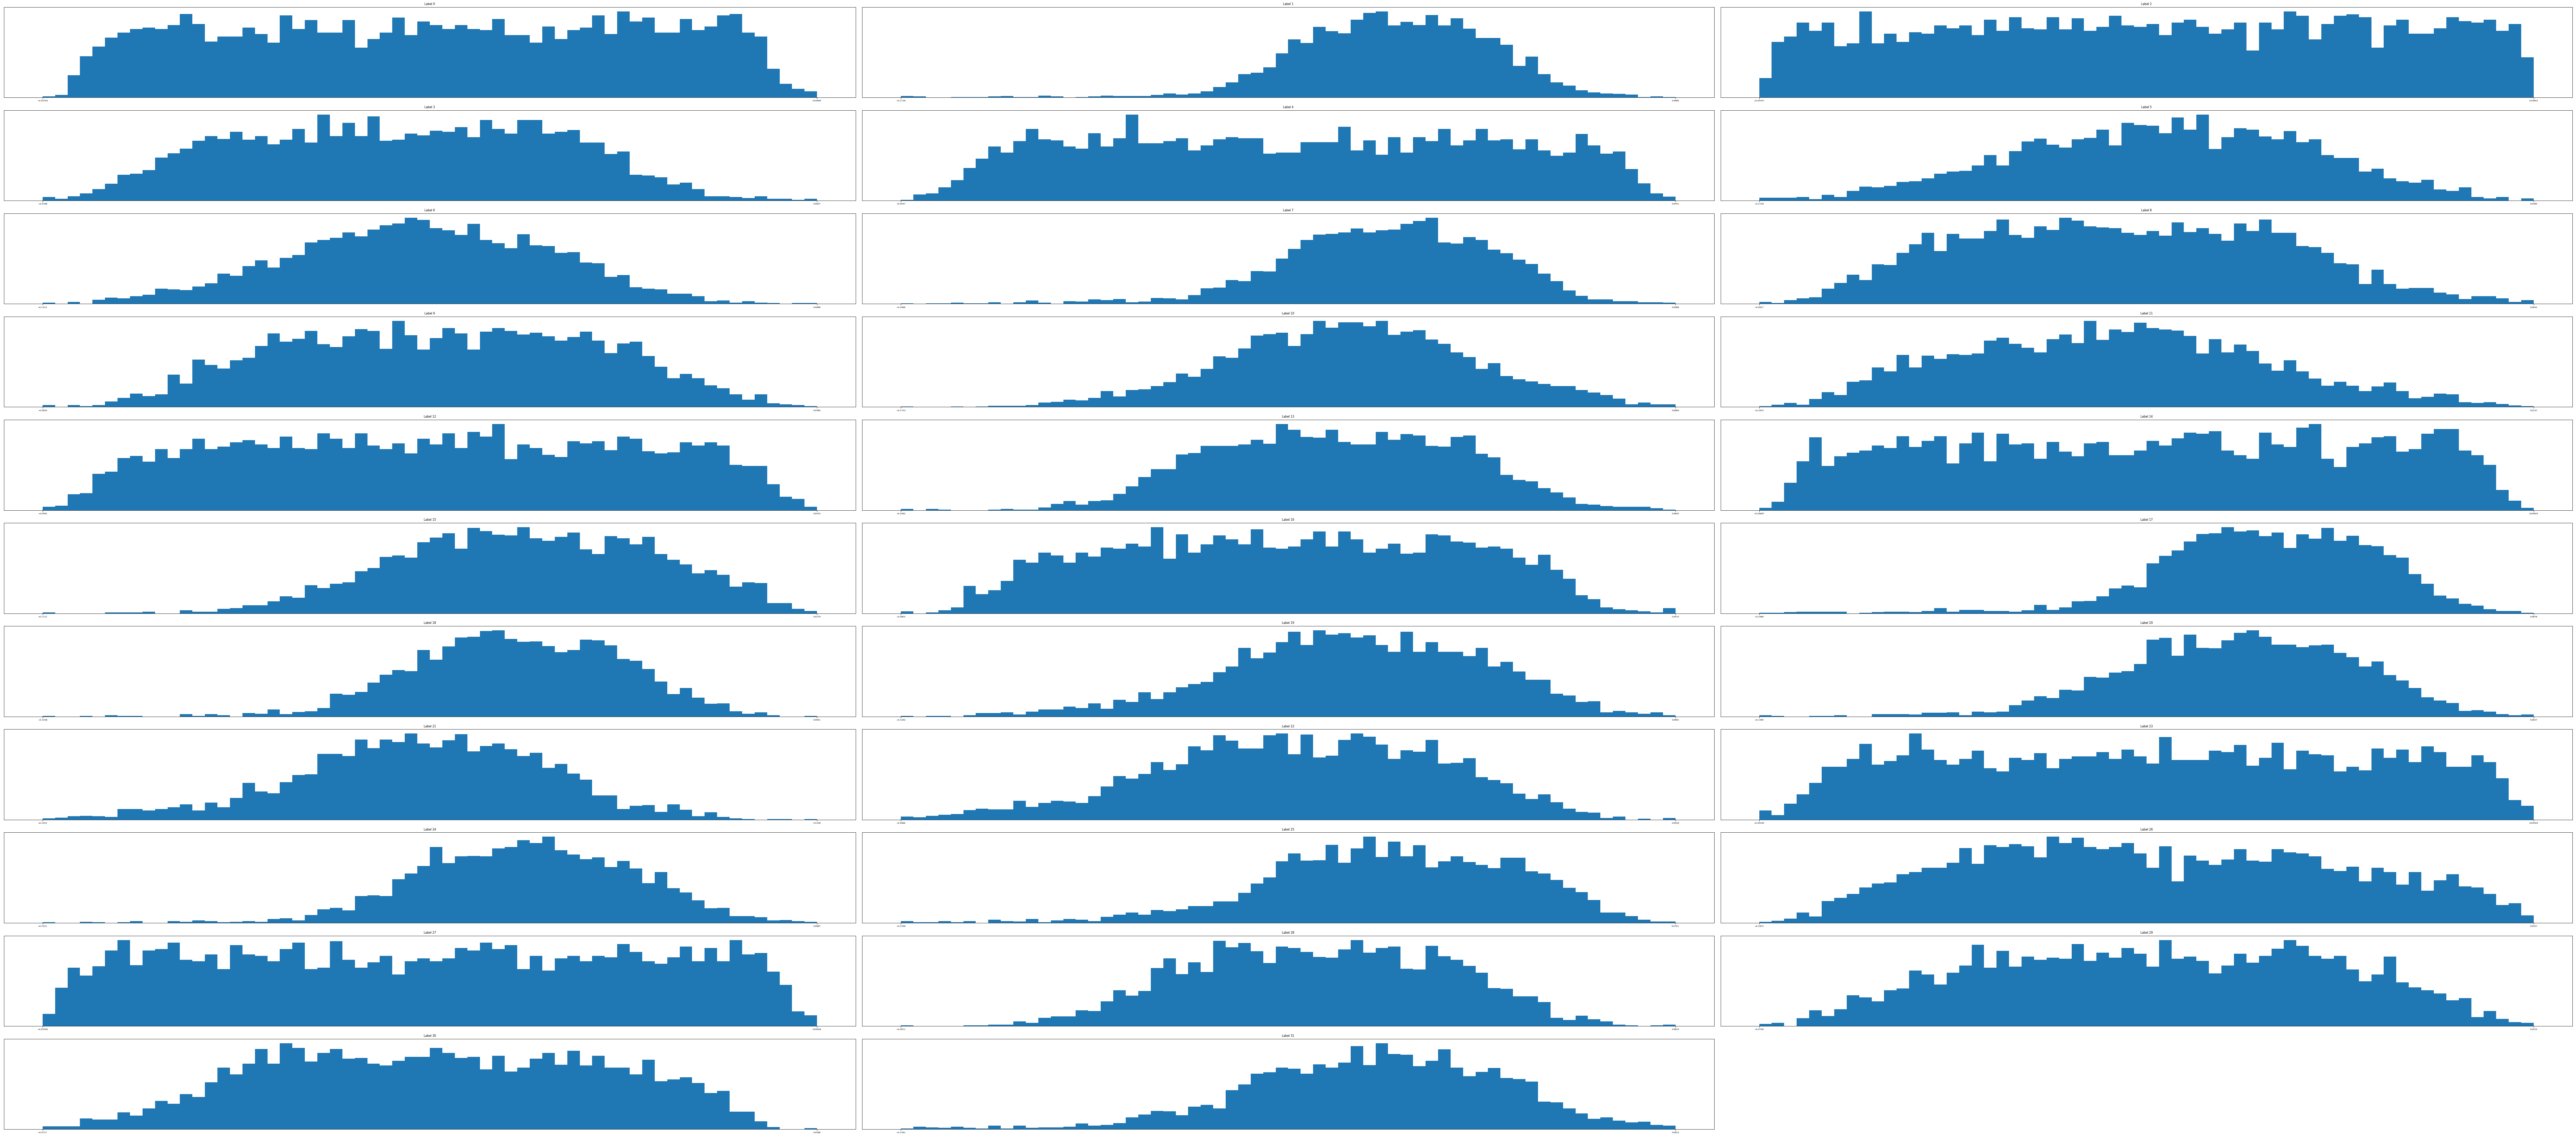

In [43]:
display_histograms(m2_weights,32)